In [40]:
import os
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import (
    GARCH, 
    ARCH, 
    Naive
)

from lib.utils import get_polygon_root, get_polygon_freq, log_returns

In [61]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess dataframe for statsforecast
    """
    df = df.ffill() # fill missing values with previous value
    df = df.dropna() # drop remaining missing values (first row)
    assert df.isnull().sum().sum() == 0, "Missing values in dataframe"

    df.rename(columns={'est': 'ds'}, inplace=True) # rename column to ds
    df.sort_values(by='ds', inplace=True) # sort by ds (have to do this before getting log returns)
    df.reset_index(drop=True, inplace=True) # reset index after sorting

    df.loc[:, 'log_rt'] = log_returns(df['close']) # get log returns

    df = df[['ticker', 'log_rt', 'ds']].rename(columns={
    'log_rt' : 'y',
    'ticker' : 'unique_id'
    }) # select only relevant columns and rename

    return df

In [50]:
data = f"{get_polygon_root()}/sp500-5yr-hourly"
all_tickers = set([path.split("_")[0] for path in os.listdir(data) if path.endswith(".csv")])
all_paths = set([path for path in os.listdir(data) if path.endswith(".csv")])

# tickers = ['MSFT', 'AAPL', 'GOOG']
tickers = ["MSFT"]
paths = [f"{ticker}_2018-07-03_2023-07-01.csv" for ticker in tickers]

In [51]:
paths

['MSFT_2018-07-03_2023-07-01.csv']

In [60]:
dfs = [pd.read_csv(f"{data}/{path}") for path in paths]
returns = [preprocess_daily(df) for df in dfs]

KeyError: 'close'

In [31]:
concat = pd.concat(returns)

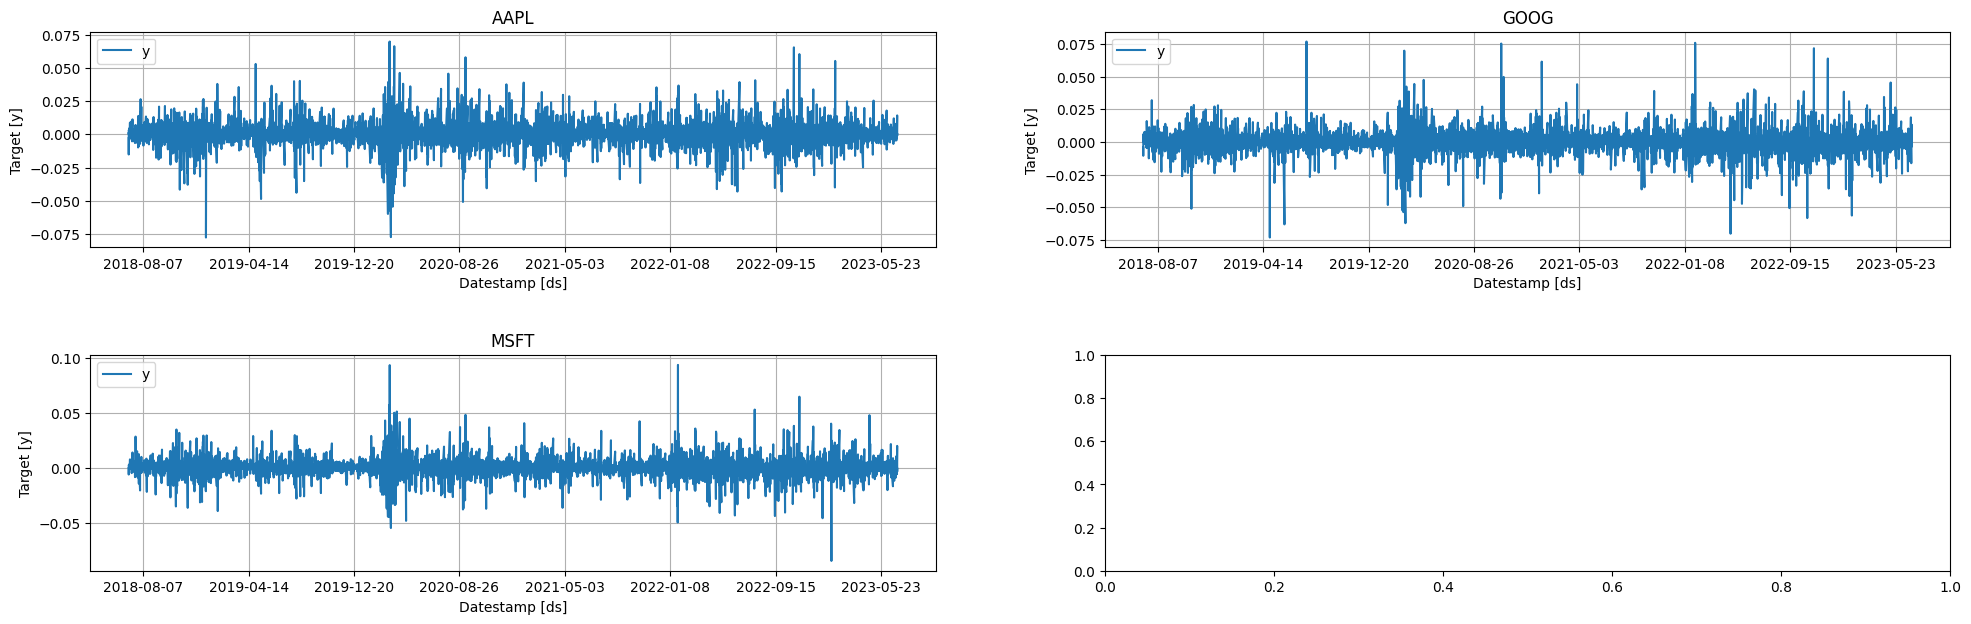

In [39]:
StatsForecast.plot(concat)

In [41]:
models = [ARCH(1), 
          ARCH(2), 
          GARCH(1,1),
          GARCH(1,2),
          GARCH(2,2),
          GARCH(2,1),
          Naive()
]

In [42]:
sf = StatsForecast(
    df = concat, 
    models = models, 
    freq = get_polygon_freq(),
    n_jobs = -1
)

In [43]:
crossvalidation_df = sf.cross_validation(
    df = concat,
    h = 7, # one day out
    step_size = 7, 
    n_windows = 10,
)

In [44]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

,unique_id,ds,cutoff,actual,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
0,AAPL,2023-06-20 11:00:00,2023-06-20 10:00:00,0.004100,0.353438,0.179225,0.252207,0.245315,0.203980,0.345255,0.000757
1,AAPL,2023-06-20 12:00:00,2023-06-20 10:00:00,-0.001023,-0.133111,-0.067499,-0.094986,-0.092390,-0.076823,-0.130029,0.000757
2,AAPL,2023-06-20 13:00:00,2023-06-20 10:00:00,-0.000394,-0.114924,-0.058277,-0.082008,-0.079767,-0.066326,-0.112263,0.000757
3,AAPL,2023-06-20 14:00:00,2023-06-20 10:00:00,-0.002412,-0.233465,-0.118388,-0.166597,-0.162044,-0.134740,-0.228060,0.000757
4,AAPL,2023-06-20 15:00:00,2023-06-20 10:00:00,-0.001298,0.188303,0.095486,0.134369,0.130697,0.108675,0.183943,0.000757


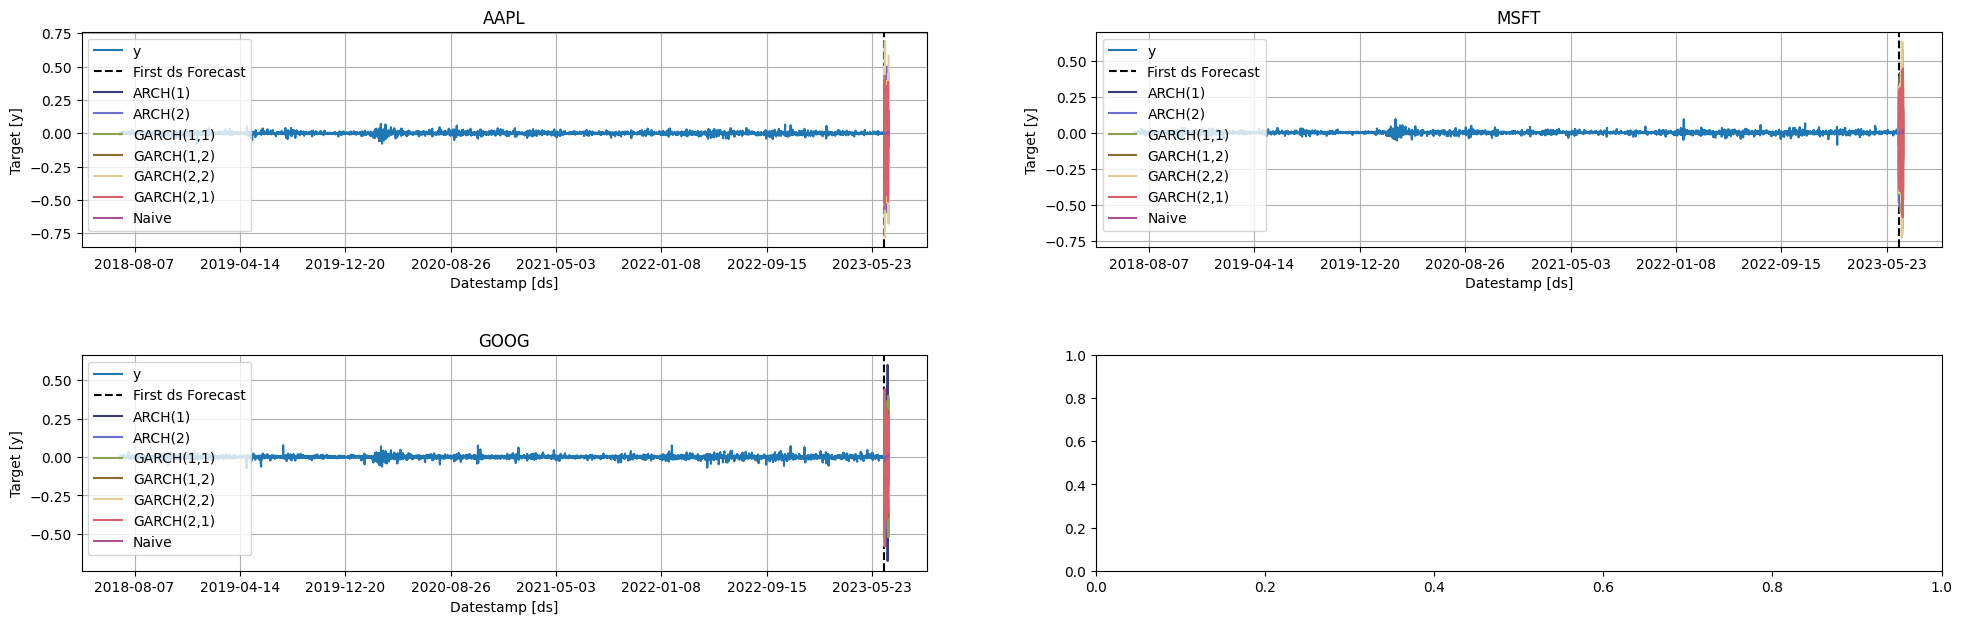

In [49]:
StatsForecast.plot(concat, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))